# Install libraries 


In [1]:
import sys, os
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation



## torch libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_v3

# Preproc and Save dataset 
Frequence which we extract 

In [3]:
np.logspace(np.log10(1), np.log10(99), 16)

array([ 1.        ,  1.3584459 ,  1.84537525,  2.50684244,  3.40540983,
        4.62606501,  6.28425903,  8.53682589, 11.59681611, 15.75364725,
       21.40047747, 29.07139081, 39.49191155, 53.6476252 , 72.87739632,
       99.        ])

## NODDI DATASET


In [4]:
path_to_dataset = '../data/NODDI_dataset_light/'
dataset_name = 'NODDI'
remove_confounds = True

config = dict(  
                dataset_name = dataset_name,
                new_fps=100,
                n_roi = 17,
                test_sec = 60, # in seconds.
                freqs = np.logspace(np.log10(1), np.log10(99), 16), 
                crop_start = 5
                )

In [5]:
for patient in ['32']:

    df_eeg_cwl_raw, df_fmri_cwl_raw, labels_roi = get_datasets.download_bids_noddi_dataset(patient, path_to_dataset, 
                                                                        remove_confounds=remove_confounds,
                                                                        verbose=True)
    df_eeg_cwl, df_fmri_cwl, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg_cwl_raw, df_fmri_cwl_raw)
    config['fps'] = fps
    print('Original FPS', config['fps']) 
    
    # delete time columns. 
    # reshape [time, ch] -> [ch, time]
    eeg_np = df_eeg_cwl.drop(['time'], axis=1).to_numpy().T
    fmri_np = df_fmri_cwl.drop(['time'], axis=1).to_numpy().T

    dataset_train, dataset_test = preproc.divide_train_test(eeg_np, fmri_np,
                                                            fps=config['fps'], 
                                                            test_sec=config['test_sec'])



    train_dataset_prep, freqs, inp_stats_train, out_stats_train = preproc.preproc_dataset(dataset_train, 
                                                                                          fps=config['fps'], 
                                                                                          freqs=config['freqs'], 
                                                                                          inp_means_stds=None, 
                                                                                          out_means_stds=None)
    test_dataset_prep, freqs, inp_stats_test, out_stats_test = preproc.preproc_dataset(dataset_test,
                                                                                        fps = config['fps'],
                                                                                        freqs = config['freqs'],                                                                    
                                                                                        inp_means_stds=None, 
                                                                                        out_means_stds=None)
    # # downsample if needed 
    ds_factor = config['fps']/config['new_fps']

    train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
    test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)

    print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
    print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)
    
    
    
    y_train=train_dataset_prep[1]
    y_test=test_dataset_prep[1]
    
    x_train = np.clip(train_dataset_prep[0], 0, np.max(train_dataset_prep[0]))
    x_test = np.clip(test_dataset_prep[0], 0, np.max(test_dataset_prep[0]))
    
    x_train = 10 * np.log10(x_train + 1e-6)
    x_test = 10 * np.log10(x_test + 1e-6)
    
    
    # remove starting artifacts.
    train_crop = config['crop_start']*config['new_fps']
    x_train , y_train = x_train[..., train_crop:], y_train[..., train_crop:]
    
    np.savez(f'../data/preproc/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_1_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)





ALL path:  ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_desc-confounds_timeseries.tsv ../data/NODDI_dataset_light/derivatives/sub-32/func/sub-32_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json ../data/NODDI_dataset_light/derivatives/sub-32/eeg/sub-32_task-rest_eeg.vhdr


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:392: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(eeg_preproc_path, preload=True, verbose=False)


Dimension of our EEG data:  (162023, 65)
Dimension of our fMRi data:  (97, 115, 97, 300)
Dimension of our fMRi Roi data:  (300, 18)
fMRI info: {'RepetitionTime': 2.16, 'SkullStripped': False, 'SliceTimingCorrected': True, 'StartTime': 1.049, 'TaskName': 'rest'}
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Original FPS 250
Size of train dataset: eeg (64, 146460) | fmri (17, 146460)
Size of test dataset: eeg (64, 15000) | fmri (17, 15000)
Size of eeg features (64, 16, 146460) | fmri (17, 146460)
Size of eeg features (64, 16, 15000) | fmri (17, 15000)
Size of train dataset: (64, 16, 58584) (17, 58584)
Size of test dataset: (64, 16, 6000) (17, 6000)


## CWL DATASET

In [7]:
path_to_dataset = '../data/eyes_open_closed_dataset/'
dataset_name = 'CWL'
remove_confounds = True

config = dict(  
                dataset_name = dataset_name,
                new_fps=100,
                n_roi = 17,
                test_sec = 60, # in seconds.
                crop_start = 5,

                freqs = np.logspace(np.log10(1), np.log10(99), 16), 
                )

In [8]:
for patient in ['trio1', 'trio2', 'trio3', 'trio4']:

    df_eeg_cwl_raw, df_fmri_cwl_raw, labels_roi = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
                                                                        remove_confounds=remove_confounds,
                                                                        verbose=True)
    df_eeg_cwl, df_fmri_cwl, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg_cwl_raw, df_fmri_cwl_raw)
    config['fps'] = fps
    print('Original FPS', config['fps']) 
    
    # delete time columns. 
    # reshape [time, ch] -> [ch, time]
    eeg_np = df_eeg_cwl.drop(['time'], axis=1).to_numpy().T
    fmri_np = df_fmri_cwl.drop(['time'], axis=1).to_numpy().T

    dataset_train, dataset_test = preproc.divide_train_test(eeg_np, fmri_np,
                                                            fps=config['fps'], 
                                                            test_sec=config['test_sec'])



    train_dataset_prep, freqs, inp_stats_train, out_stats_train = preproc.preproc_dataset(dataset_train, 
                                                                                          fps=config['fps'], 
                                                                                          freqs=config['freqs'], 
                                                                                          inp_means_stds=None, 
                                                                                          out_means_stds=None)
    test_dataset_prep, freqs, inp_stats_test, out_stats_test = preproc.preproc_dataset(dataset_test,
                                                                                        fps = config['fps'],
                                                                                        freqs = config['freqs'],                                                                    
                                                                                        inp_means_stds=None, 
                                                                                        out_means_stds=None)
    # # downsample if needed 
    ds_factor = config['fps']//config['new_fps']

    train_dataset_prep = preproc.downsample_dataset(train_dataset_prep, factor = ds_factor)
    test_dataset_prep = preproc.downsample_dataset(test_dataset_prep, factor = ds_factor)

    print('Size of train dataset:', train_dataset_prep[0].shape, train_dataset_prep[1].shape)
    print('Size of test dataset:', test_dataset_prep[0].shape, test_dataset_prep[1].shape)

    y_train = train_dataset_prep[1]
    y_test = test_dataset_prep[1]
    
    x_train = np.clip(train_dataset_prep[0], 0, np.max(train_dataset_prep[0]))
    x_test = np.clip(test_dataset_prep[0], 0, np.max(test_dataset_prep[0]))
    
    x_train = 10 * np.log10(x_train + 1e-6)
    x_test = 10 * np.log10(x_test + 1e-6)
    
    
    # remove starting artifacts.
    train_crop = config['crop_start']*config['new_fps']
    x_train , y_train = x_train[..., train_crop:], y_train[..., train_crop:]
    
    np.savez(f'../data/preproc/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_1_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)





ALL path:  ../data/eyes_open_closed_dataset/trio1/CWL_Data/eeg/in-scan/trio1_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_normalized/rwatrio1_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio1/CWL_Data/mri/epi_motionparams/rp_atrio1_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (303601, 31)
Dimension of our fMRi data:  (61, 72, 61, 146)
Dimension of our fMRi Roi data:  (143, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Original FPS 1000
Size of train dataset: eeg (30, 216900) | fmri (17, 216900)
Size of test dataset: eeg (30, 60000) | fmri (17, 60000)


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()


Size of eeg features (30, 16, 216900) | fmri (17, 216900)
Size of eeg features (30, 16, 60000) | fmri (17, 60000)
Size of train dataset: (30, 16, 21690) (17, 21690)
Size of test dataset: (30, 16, 6000) (17, 6000)
ALL path:  ../data/eyes_open_closed_dataset/trio2/CWL_Data/eeg/in-scan/trio2_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio2/CWL_Data/mri/epi_normalized/rwatrio2_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio2/CWL_Data/mri/epi_motionparams/rp_atrio2_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (296201, 31)
Dimension of our fMRi data:  (61, 72, 61, 150)
Dimension of our fMRi Roi data:  (145, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Original FPS 1000
Size of train dataset: eeg (30, 220800) | fmri (17, 220800)
Size of test dataset: eeg (30, 60000) | fmri (17, 60000)


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()


Size of eeg features (30, 16, 220800) | fmri (17, 220800)
Size of eeg features (30, 16, 60000) | fmri (17, 60000)
Size of train dataset: (30, 16, 22080) (17, 22080)
Size of test dataset: (30, 16, 6000) (17, 6000)
ALL path:  ../data/eyes_open_closed_dataset/trio3/CWL_Data/eeg/in-scan/trio3_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio3/CWL_Data/mri/epi_normalized/rwatrio3_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio3/CWL_Data/mri/epi_motionparams/rp_atrio3_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (321881, 31)
Dimension of our fMRi data:  (61, 72, 61, 144)
Dimension of our fMRi Roi data:  (144, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Original FPS 1000
Size of train dataset: eeg (30, 218850) | fmri (17, 218850)
Size of test dataset: eeg (30, 60000) | fmri (17, 60000)


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()


Size of eeg features (30, 16, 218850) | fmri (17, 218850)
Size of eeg features (30, 16, 60000) | fmri (17, 60000)
Size of train dataset: (30, 16, 21885) (17, 21885)
Size of test dataset: (30, 16, 6000) (17, 6000)
ALL path:  ../data/eyes_open_closed_dataset/trio4/CWL_Data/eeg/in-scan/trio4_mrcorrected_eoec_in-scan_hpump-off.set ../data/eyes_open_closed_dataset/trio4/CWL_Data/mri/epi_normalized/rwatrio4_eoec_in-scan_hpump-off.nii ../data/eyes_open_closed_dataset/trio4/CWL_Data/mri/epi_motionparams/rp_atrio4_eoec_in-scan_hpump-off.txt


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:215: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_confound = pd.read_csv(motion_params_path, sep = '  ', header=None)


Dimension of our EEG data:  (323416, 31)
Dimension of our fMRi data:  (61, 72, 61, 150)
Dimension of our fMRi Roi data:  (149, 18)
fMRI info :  1.95
RoI:  ['Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'time']
Original FPS 1000
Size of train dataset: eeg (30, 228600) | fmri (17, 228600)
Size of test dataset: eeg (30, 60000) | fmri (17, 60000)


/home/user/common/koval_alvi/eeg-fmri-project/utils/get_datasets.py:261: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  return df_eeg, df_fmri, df_fmri.drop(['time'], 1).columns.to_list()


Size of eeg features (30, 16, 228600) | fmri (17, 228600)
Size of eeg features (30, 16, 60000) | fmri (17, 60000)
Size of train dataset: (30, 16, 22860) (17, 22860)
Size of test dataset: (30, 16, 6000) (17, 6000)


## Save labels roi 

In [ ]:
# saving 
import json

with open("..data/preproc/CWL/labels_roi.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(labels_roi, f, indent=2) 




# Visualization 

In [9]:
trio_cwl = np.load('../data/preproc/CWL/trio1_100_hz_17_roi_1_99_freqs.npz')

In [10]:
trio_nod = np.load('../data/preproc/NODDI/32_100_hz_17_roi_1_99_freqs.npz')

(array([1.44640e+04, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        5.00000e+00, 5.00000e+00, 5.00000e+00, 3.00000e+00, 1.00000e+00,
        7.00000e+00, 8.00000e+00, 8.00000e+00, 7.00000e+00, 1.10000e+01,
        1.40000e+01, 1.70000e+01, 1.90000e+01, 1.80000e+01, 2.60000e+01,
        3.50000e+01, 3.10000e+01, 4.00000e+01, 5.50000e+01, 7.90000e+01,
        9.10000e+01, 1.02000e+02, 1.29000e+02, 2.13000e+02, 2.29000e+02,
        2.39000e+02, 3.32000e+02, 4.08000e+02, 5.25000e+02, 6.28000e+02,
        8.16000e+02, 1.04500e+03, 1.33700e+03, 1.84600e+03, 2.23300e+03,
        2.74300e+03, 3.60500e+03, 4.30100e+03, 5.68600e+03, 6.94000e+03,
        8.64600e+03, 1.05990e+04, 1.31310e+04, 1.60820e+04, 1.95150e+04,
        2.38230e+04, 2.87840e+04, 3.46270e+04, 4.15710e+04, 4.90260e+04,
        5.81580e+04, 6.83820e+04, 8.02260e+04, 9.21780e+04, 1.04813e+05,
        1.18236e+05, 1.31744e+05, 1.45400e+05, 1.56

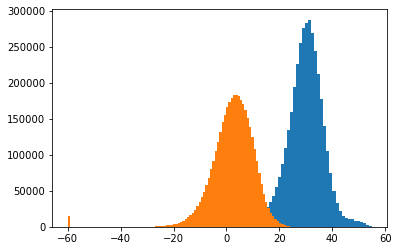

In [18]:
plt.hist(trio_['x_train'][:, 0, :].reshape(-1), bins =100)
plt.hist(trio_['x_train'][:, -1, :].reshape(-1), bins =100)

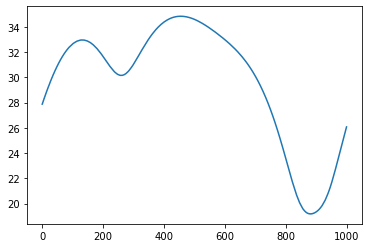

In [19]:
plt.plot(trio_['x_test'][20, 0, :1000])

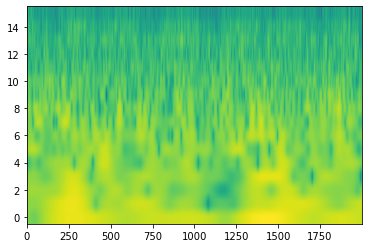

In [22]:
plt.imshow(trio_['x_test'][30, :, :2000], aspect='auto', origin = 'lower')

In [26]:
trio_['y_train'].shape

(17, 58584)

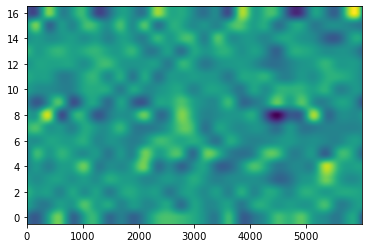

In [23]:
plt.imshow(trio_['y_test'], aspect='auto', origin = 'lower')

In [18]:
# np.savez(f'../data/preproc/NODDI/{patient}_NODDI_250_hz_17_roi_1_49_freqs', 
#          x_train=train_dataset_prep[0], y_train=train_dataset_prep[1],
#          x_test=test_dataset_prep[0], y_test=test_dataset_prep[1])


# Confounds 

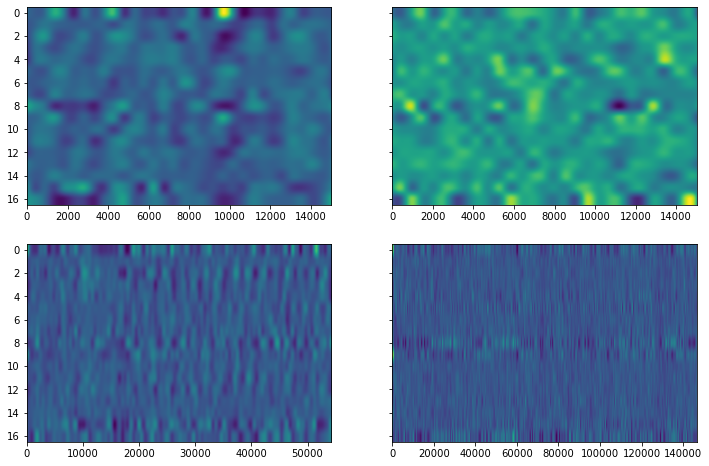

In [10]:
fmri_cwl_train, fmri_cwl_test = fmri_cwl[:, :-60*250],  fmri_cwl[:, -60*250:]
fmri_noddi_train, fmri_noddi_test = fmri_noddi[:, :-60*250],  fmri_noddi[:, -60*250:] 

fig, ax = plt.subplots(2, 2, figsize = (12, 8), sharey=True)
ax[0, 0].imshow(fmri_cwl_test, aspect = 'auto')
ax[0, 1].imshow(fmri_noddi_test, aspect = 'auto')
ax[1, 0].imshow(fmri_cwl_train, aspect = 'auto')
ax[1, 1].imshow(fmri_noddi_train, aspect = 'auto')


from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


correlation_matrix = correlation_measure.fit_transform([fmri_cwl_train.T])[0]
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)

print('CWL test')
print('Train mean corr ', np.mean(np.abs(correlation_matrix)))


correlation_matrix = correlation_measure.fit_transform([fmri_cwl_test.T])[0]
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)
print('Test mean corr ', np.mean(np.abs(correlation_matrix)))




from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


correlation_matrix = correlation_measure.fit_transform([fmri_noddi_train.T])[0]
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)

print('CWL test')
print('Train mean corr ', np.mean(np.abs(correlation_matrix)))


correlation_matrix = correlation_measure.fit_transform([fmri_noddi_test.T])[0]
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)
print('Test mean corr ', np.mean(np.abs(correlation_matrix)))


['Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']


In [51]:
np.savez('dataset_NODDI_250_hz', 
         x_train=train_dataset_prep[0], y_train=train_dataset_prep[1],
         x_test=test_dataset_prep[0], y_test=test_dataset_prep[1])


# 